# Polarization behaviors on Twitter: holistic analysis

In this notebook, the following steps are performed:
* Computation of studied polarization factors (normalized entropy)
* Computation of polarization scores, using the GRAIL metric
* Identification of behavioral classes, using the k-means algorithm
* Characterization of behavioral classes, using hierarchial regression

It can be run for two debates: 
* The COVID-19 debate, opposing the pro-vaccine and anti-vaccine communities.
* The Ukraine conflict debate, opposing the pro-Ukraine and pro-Russia communities. 

At certain stages, it is needed to comment and/or uncomment the code, depending on the debate being studied. 
By default, the Ukraine conflict debate is studied.

# Libraries import

As a first step, all necessary libraries are imported

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook
from scipy.stats import entropy
import itertools
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import davies_bouldin_score

# Data import

Then, data are imported. 
For the holistic analysis, two datasets are required:
* edges: contains all the links between standard users and elite users (sources). One link corresponds to one retweet. 
* factors_data: contains computed factors for each standard users. These factors are either computed directly from collected dataset (number of retweets, proportion of retweets on the studied debate, frequency of interactions, number of elite users retweeted in each community), or from the graph built from the collected dataset (proximity centrality, betweenness centrality, PageRank)

In [3]:
#Required data to study the vaccine debate 
# edges = pd.read_csv('../data/vaccine_debate/interactions_vaccine_debate.csv', index_col=0)
# factors_data = pd.read_csv('../data/vaccine_debate/indicators_vaccine_debate.csv', index_col=0)

#Required data to study the Ukraine conflict debate
edges = pd.read_csv('../data/ukraine_debate/interactions_ukraine_debate.csv', index_col=0)
factors_data = pd.read_csv('../data/ukraine_debate/indicators_ukraine_debate.csv', index_col=0)

In [4]:
edges.head()

,Source,Target,Timeset,Side
0,S0V,E0V,2022-07-30,provax
1,S0V,E0V,2022-07-30,provax
2,S0V,E1V,2022-07-27,provax
3,S0V,E1V,2022-07-25,provax
4,S0V,E1V,2022-07-19,provax


In [5]:
print('Number of standard users:', edges['Source'].nunique())
print('Number of elite users:', edges['Target'].nunique())
print('Number of retweets:',len(edges))

Number of standard users: 1000
Number of elite users: 20
Number of retweets: 299882


In [6]:
#Create a list with identifier of each user
retweeters = edges['Source'].unique().tolist()

In [7]:
#Create lists with identifier of elite users of each community

#Vaccine debate
# provax_usernames = edges[edges['Side']=='provax']['Target'].unique().tolist()
# antivax_usernames = edges[edges['Side']=='antivax']['Target'].unique().tolist()

#Ukraine conflict debate
prorussia_usernames = edges[edges['Side']=='prorussia']['Target'].unique().tolist()
proukraine_usernames = edges[edges['Side']=='proukraine']['Target'].unique().tolist()

In [8]:
#vaccine_usernames = provax_usernames + antivax_usernames
war_usernames = prorussia_usernames + proukraine_usernames

# Polarization factors computation

3 polarization factors are studied: 
* Opinions, noted $H'_O$.
* Sources, in one community, noted $H'_{s,pro}$ or $H'_{s,proU}$ for the vaccine and Ukraine conflict debate respectively.  
* Sources, in the opppsing community, noted $H'_{s,anti}$ or $H'_{s,proR}$ for the vaccine and Ukraine conflict debate respectively.  

Each factor is computed with normalized entropy.
The sign of the opinion factor $H'_O$ is set according to the community within which the user interact more, and therefore ranges in [-1,1] . This allows to differentiate users accessing more one community or the other. For the clustering process, $H'_O$ is transformed so that it is included in [0,1]. To this end, computed $H'_o$ values are transformed using $H'_otrans = \frac{H'_o+1}{2}$. 

In [9]:
def normalized_entropy(distribution):
    return entropy(distribution, base=2)/np.log2(len(distribution))

In [10]:
#Function to compute factors
def compute_new_polarization_index_terms(edges_df, list_users, comm1, comm2, comm1_usernames, comm2_usernames):
    dict_x_term ={}
    dict_y_term_comm1 = {}
    dict_y_term_comm2 = {}

    nb_communities = 2
    nb_mentors_C1 = len(comm1_usernames)
    nb_mentors_C2 = len(comm2_usernames)
    list_usernames_total = comm1_usernames + comm2_usernames

    for i in tqdm(range(len(list_users))):
        df_user = edges_df[edges_df['Source']==list_users[i]] 
        comm1_links = len(df_user[df_user['Side']==comm1])
        comm2_links = len(df_user[df_user['Side']==comm2])
        degree = len(df_user)

        PC_user = [comm1_links/degree, comm2_links/degree]
        w1 = PC_user[0]
        w2 = PC_user[1]
        
        PM1_user = []
        PM2_user = []
        PM_user = []
        nb_communities_user = 0

        if comm1_links > 0:
            nb_communities_user = nb_communities_user+1          
            for j in range(len(comm1_usernames)): 
                nb_links_mentor_j = len(df_user[df_user['Target']==comm1_usernames[j]])
                PM1_user.append(nb_links_mentor_j/comm1_links)
        
        if comm2_links > 0:
            nb_communities_user = nb_communities_user+1
            for j in range(len(comm2_usernames)):
                nb_links_mentor_j = len(df_user[df_user['Target']==comm2_usernames[j]])
                PM2_user.append(nb_links_mentor_j/comm2_links)


        #Opinion factor
        Ho_user = normalized_entropy(PC_user)


        #Sources C1 factor
        if comm1_links > 0:
            Hs_user_comm1 = normalized_entropy(PM1_user)
        else :
            Hs_user_comm1 = 1

        #Sources C2 factor
        if comm2_links > 0:
            Hs_user_comm2 = normalized_entropy(PM2_user)
        else:
            Hs_user_comm2 = 1
        

        if w1 >= w2:
            dict_key = {list_users[i]:1-Ho_user}
            dict_x_term.update(dict_key)
        elif w1 < w2:
            dict_key = {list_users[i]:-(1-Ho_user)}
            dict_x_term.update(dict_key)


        dict_key = {list_users[i]:1-Hs_user_comm1}
        dict_y_term_comm1.update(dict_key)

        dict_key = {list_users[i]:1-Hs_user_comm2}
        dict_y_term_comm2.update(dict_key)

    return dict_x_term, dict_y_term_comm1, dict_y_term_comm2

In [11]:
#dict_x_term, dict_y_provax, dict_y_antivax = compute_new_polarization_index_terms(edges, retweeters, 'provax', 'antivax', provax_usernames, antivax_usernames)
dict_x_term, dict_y_proukraine, dict_y_prorussia = compute_new_polarization_index_terms(edges, retweeters, 'proukraine', 'prorussia', proukraine_usernames, prorussia_usernames)

100%|██████████| 1000/1000 [00:24<00:00, 40.87it/s]


In [12]:
#Creation of a DataFrame containing each factor

# df_polarization_index = pd.DataFrame.from_dict(dict_x_term, orient='index', columns=['x_term'])
# df_polarization_index['x_term_trans'] = (df_polarization_index['x_term']+1)/2
# df_polarization_index['y_term_provax'] = df_polarization_index.index.map(dict_y_provax)
# df_polarization_index['y_term_antivax'] = df_polarization_index.index.map(dict_y_antivax)

df_polarization_index = pd.DataFrame.from_dict(dict_x_term, orient='index', columns=['x_term'])
df_polarization_index['x_term_trans'] = (df_polarization_index['x_term']+1)/2
df_polarization_index['y_term_proukraine'] = df_polarization_index.index.map(dict_y_proukraine)
df_polarization_index['y_term_prorussia'] = df_polarization_index.index.map(dict_y_prorussia)

In [13]:
df_polarization_index.head()

,x_term,x_term_trans,y_term_provax,y_term_antivax
S0V,0.963725,0.981862,0.180960,1.0
S1V,0.657057,0.828529,0.813457,1.0
S2V,1.000000,1.000000,0.413996,0.0
S3V,1.000000,1.000000,0.211324,0.0
S4V,1.000000,1.000000,0.196095,0.0


To better discriminate between users, the computed terms are transformed following a polynomial transformation $\frac{x^a}{x^a+(1-x)^a}$.

Tha value of parameter $a$ has been previously optimized. Here are the optimized value for each topic:

COVID-19 vaccine debate:
* $a = 1/2$

Ukraine conflict debate:
* $a = 1/3$ 

In [14]:
#Vaccine debate
#a=1/2

#Ukraine debate
a=1/3

In [15]:
def f_sigmoid_optim(x):
    return(x**(a)/(x**(a)+(1-x)**(a)))

In [16]:
# df_polarization_index['x_final'] = df_polarization_index['x_term_trans'].apply(f_sigmoid_optim)
# df_polarization_index['y_pro_final'] = df_polarization_index['y_term_provax'].apply(f_sigmoid_optim)
# df_polarization_index['y_anti_final'] = df_polarization_index['y_term_antivax'].apply(f_sigmoid_optim)

df_polarization_index['x_final'] = df_polarization_index['x_term_trans'].apply(f_sigmoid_optim)
df_polarization_index['y_proU_final'] = df_polarization_index['y_term_proukraine'].apply(f_sigmoid_optim)
df_polarization_index['y_proR_final'] = df_polarization_index['y_term_prorussia'].apply(f_sigmoid_optim)

In [17]:
df_polarization_index.head()

,x_term,x_term_trans,y_term_provax,y_term_antivax,x_final,y_pro_final,y_anti_final
S0V,0.963725,0.981862,0.180960,1.0,0.880348,0.319748,1.0
S1V,0.657057,0.828529,0.813457,1.0,0.687319,0.676190,1.0
S2V,1.000000,1.000000,0.413996,0.0,1.000000,0.456675,0.0
S3V,1.000000,1.000000,0.211324,0.0,1.000000,0.341081,0.0
S4V,1.000000,1.000000,0.196095,0.0,1.000000,0.330607,0.0


# Identification of polarization behavior classes

Here we apply the clustering step on computed factors.

## Necessary functions

In [18]:
#Search for the optimal value of k
def optimal_k_means(X):
    res = pd.DataFrame(columns=['k','Silhouette_index','DaviesBouldin_index'])
    for k in range(2, 13, 1):
        model = KMeans(n_clusters=k)
        model.fit_predict(X)
        db = davies_bouldin_score(X, model.labels_)
        silhouette_avg = silhouette_score(X, model.labels_)
        res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)  
    return res

In [19]:
#Application of the k-means algorithm with the selected optimal value of k
def apply_k_means(X, k_opt):
    model = KMeans(n_clusters=k_opt)
    model.fit_predict(X)

    cluster_labels = model.labels_
    centers = pd.DataFrame(data=model.cluster_centers_, columns=X.columns)
    clusters = pd.DataFrame(centers, columns = X.columns)

    labels_df = pd.DataFrame(model.labels_.tolist(), columns=['Cluster'])
    size_clusters = labels_df.groupby('Cluster').size()
    size_clusters = size_clusters.to_frame()
    size_clusters.columns=['size']
    sizes = size_clusters['size'].tolist()
    clusters['size'] = sizes
    cols = clusters.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    clusters = clusters[cols]
    clusters = clusters.round(2)
    clusters = clusters.T

    return cluster_labels, centers, clusters

In [20]:
#Get resulting silhouette plot
def get_silhouette_plot(X, k_opt):
    model = KMeans(n_clusters=k_opt)
    model.fit_predict(X)
    DB = davies_bouldin_score(X, model.labels_)
    print('Davies Bouldin Index : ', DB)

    silhouette_avg = silhouette_score(X, model.labels_)
    print('Silhouette Index : ', silhouette_avg)

    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(12, 6)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (model.n_clusters + 1) * 10])

    sample_silhouette_values = silhouette_samples(X, model.labels_)
    y_lower = 10
    for i in range (model.n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[model.labels_ == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / model.n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([]) 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % model.n_clusters),
                fontsize=14, fontweight='bold')

## Clustering step

In [21]:
#We create a dataframe that will be used for the clustering
X = pd.DataFrame(columns=['x_final', 'y_pro_final', 'y_anti_final'])

For the clustering process, the euclidean distance was adapted to give more weight to the opinion factor. To simplify and enhance computational performances, we multiply each factor by a weight. Following an optimization phase, we found that the opinion factor $H'_o$ should have a weight of 0.6 (60%) to allow better clustering performances. The remaining 40% are splitted among the two sources factors $H'_{s,pro}$,$H'_{s,proU}$, or $H'_{s,anti}$, $H'_{s,proR}$. 

In [22]:
# X['x_final'] = 0.6*df_polarization_index['x_final']
# X['y_pro_final'] = 0.2 * df_polarization_index['y_pro_final']
# X['y_anti_final'] = 0.2 * df_polarization_index['y_anti_final']

X['x_final'] = 0.6*df_polarization_index['x_final']
X['y_pro_final'] = 0.2 * df_polarization_index['y_proU_final']
X['y_anti_final'] = 0.2 * df_polarization_index['y_proR_final']

In [23]:
optimal_k_means(X)

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_26408/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_26408/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_26408/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_2

C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_26408/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_26408/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_26408/2006018570.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append({'k':k, 'Silhouette_index': silhouette_avg, 'DaviesBouldin_index':db}, ignore_index=True)
C:\Users\CTREUI~1.BID\AppData\Local\Temp/ipykernel_2

,k,Silhouette_index,DaviesBouldin_index
0,2.0,0.844388,0.233514
1,3.0,0.827830,0.375079
2,4.0,0.845717,0.350255
3,5.0,0.746916,0.422175
4,6.0,0.732266,0.449446
5,7.0,0.728576,0.555889
6,8.0,0.648853,0.597534
7,9.0,0.599889,0.581239
8,10.0,0.611695,0.536427
9,11.0,0.600639,0.591383


In [24]:
#For both debates, the optimal value of k is 4
labels, centers, clusters = apply_k_means(X, 4)
sort_clusters = clusters.sort_values(by='size', ascending=False,axis=1)

In [25]:
print('Centers of identified clusters:')
sort_clusters

Centers of identified clusters:


,1,0,2,3
size,452.0,360.00,141.00,47.00
x_final,0.6,0.00,0.06,0.39
y_pro_final,0.1,0.00,0.18,0.11
y_anti_final,0.0,0.11,0.10,0.17


In [26]:
map = {}
for i in range(4):
    map[sort_clusters.columns[i]]=clusters.columns[i]
labels_map = [map[i] for i in labels]

Davies Bouldin Index :  0.3502546795975571
Silhouette Index :  0.8457172316281671


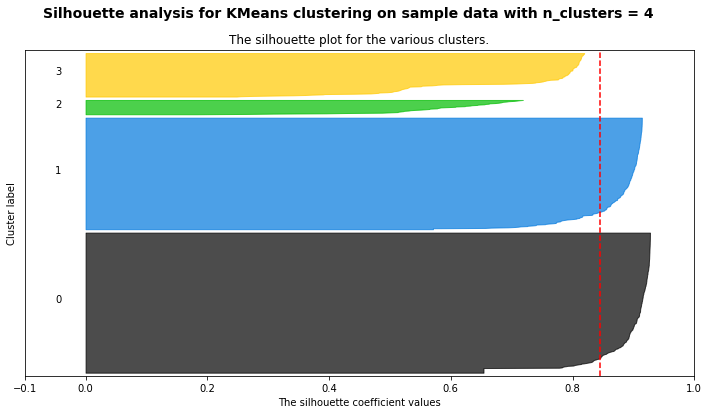

In [27]:
get_silhouette_plot(X, 4)

In [28]:
X['cluster'] = labels_map

In [29]:
df_polarization_index['cluster'] = labels_map

In [30]:
df_polarization_index.head()

,x_term,x_term_trans,y_term_provax,y_term_antivax,x_final,y_pro_final,y_anti_final,cluster
S0V,0.963725,0.981862,0.180960,1.0,0.880348,0.319748,1.0,3
S1V,0.657057,0.828529,0.813457,1.0,0.687319,0.676190,1.0,3
S2V,1.000000,1.000000,0.413996,0.0,1.000000,0.456675,0.0,0
S3V,1.000000,1.000000,0.211324,0.0,1.000000,0.341081,0.0,0
S4V,1.000000,1.000000,0.196095,0.0,1.000000,0.330607,0.0,0


In [31]:
#The final dataframe is saved in the results folder

#df_polarization_index.to_csv('../results/holistic_analysis/vaccine_debate_final_data.csv')
df_polarization_index.to_csv('../results/holistic_analysis/ukraine_conflict_debate_final_data.csv')